<a href="https://colab.research.google.com/github/UMassIonTrappers/quantum-computing-labs/blob/main/Lab_11_Shor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE 550/650 QC

## Introduction to Quantum Computing

Robert Niffenegger (rniffenegger@umass.edu )


In [2]:
try:
  import qiskit
except ImportError:
  print('Install Qiskit')
  !pip install --quiet qiskit
  !pip install --quiet qiskit[visualization]
  # !pip install --quiet git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src
  #Install Qiskit Aer so you can import QasmSimulator
  !pip install qiskit-aer

try:
  from qiskit_aer import QasmSimulator
  print('Qiskit Aer imported');
except ImportError:
  print('Install Qiskit-Aer')
  !pip install qiskit-aer
  from qiskit import QuantumCircuit, transpile, assemble
  from qiskit.visualization import plot_bloch_multivector, plot_histogram
  from qiskit_aer import QasmSimulator

Qiskit Aer imported


In [3]:
# %matplotlib inline

from IPython.display import display, Math
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi, sqrt, sin, cos

from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction

#Plot setup
from pylab import *
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML

#Qisket imports
from qiskit import *
# from qiskit.providers.ibmq import least_busy
from qiskit.visualization import plot_bloch_multivector, plot_histogram
# from qiskit.providers.aer import QasmSimulator

# from qiskit.providers.basicaer import BasicAer
# from qiskit.providers.aer.noise import *

from qiskit.quantum_info import Statevector
from qiskit.visualization import array_to_latex

# sim = Aer.get_backend("aer_simulator")

# Part II

# Shor's Algorithm

Shor’s algorithm is famous for factoring integers 'N' in polynomial time. Since the best-known classical algorithm requires superpolynomial time to factor the product of two primes, the widely used cryptosystem, RSA, relies on factoring being impossible for large enough integers.

The quantum part of Shor’s algorithm solves the problem with period finding.

Since a factoring problem can be turned into a period finding problem in polynomial time, an efficient period finding algorithm can be used to factor integers efficiently too.

So efficiently computing the period of:

 $U^x = a^x \text{ mod } N$  

allows us to efficiently factor N.

> 'a' can be any number less than N that has no common factors with N (we will start with a=2 for reasons that will become obvious when we see the circuit that implements the function).

First we will look at how to find the period of this function and then we will see how it helps us factor N.

---

References:

1. https://openlearninglibrary.mit.edu/courses/course-v1:MITx+8.370.2x+1T2018/courseware/Week3/lectures_U2_5_factoring/

1. https://research.ibm.com/blog/factor-15-shors-algorithm

1. Realization of a scalable Shor algorithm - https://arxiv.org/abs/1507.08852

1. (Demonstration of Shor’s factoring algorithm for N = 21 on IBM quantum processors) https://www.nature.com/articles/s41598-021-95973-w

1. https://www.scottaaronson.com/qclec.pdf

1. https://tsmatz.wordpress.com/2019/05/22/quantum-computing-modulus-add-subtract-multiply-exponent/

1. Quantum arithmetic with the Quantum Fourier Transform ( https://arxiv.org/abs/1411.5949 )


To get started N must be the product of two prime numbers.

Listing some primes:

In [3]:
import sympy

primes = list(sympy.primerange(0, 50))
print(primes)


[2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47]


We will use the first non trivial primes, 3 and 5 for this demo.

p = 3

q = 5

N = p*q

----

a is then any number < N that does not share a factor with N

We'll start with a = 2

For small values it is very easy to see the period of the function

 $ a^x \text{ (mod } N)$  

 just by plotting it out:

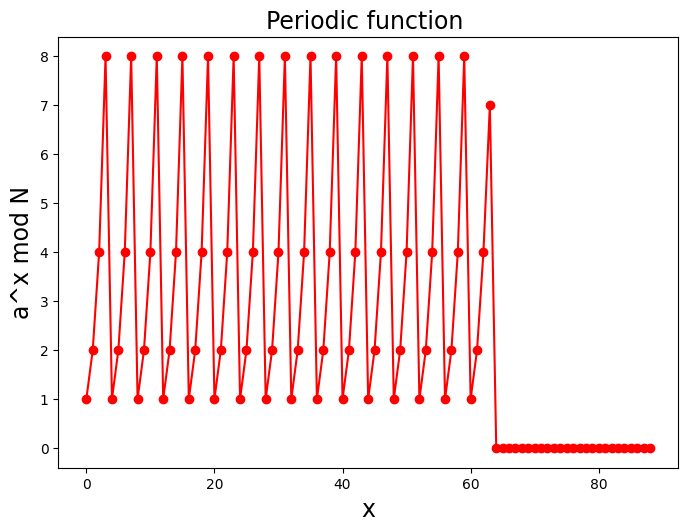

In [4]:
a = 2

N = 15

xmax = 6*N
x = arange(0,xmax-1)

f_mod = mod(a**x,N)

#Plot
figsize = 8
plt.figure(figsize=(figsize,figsize*0.7))
ax = plt.gca()
plt.style.use('default')

ax.plot(x, f_mod,'o-r')

fs=17
plt.title('Periodic function ', fontsize=fs)
ax.set_ylabel(r'a^x mod N', fontsize=fs);
ax.set_xlabel(r'x', fontsize=fs);


However, something is wrong. The function just fails after some point...

Turns out $a^{x}$ is a big number for a = 2 and x > 60 and Python has overflow errors unless we start specifying more precision in our initialization of the variables.

Instead of taking the modulo at the end we can take it at intermediate steps using the identity:

$(a ⋅ b) \text{ mod } m = [(a \text{ mod } m) ⋅ (b \text{ mod } m)] \text{ mod } m$

This is Modular Exponentiation
>https://en.wikipedia.org/wiki/Modular_exponentiation

So we will use the pow(a, x, N) function to perform Modular Exponentiation.

It can handle really big numbers:

In [5]:
'''
x = pow(a, d, n)
'''
d = 2**5
print(d)
x = pow(91, d, 131)
print(x)

32
125


## Repeated Squaring

Another trick the 'pow' function uses is repeated squaring.

For instance we can compute $a^{2^j}$ (mod N) by repeatedly squaring.

> https://en.wikipedia.org/wiki/Exponentiation_by_squaring

>https://mathlesstraveled.com/2018/08/18/modular-exponentiation-by-repeated-squaring/

We will use it in the quantum algorithm as well.

In [6]:
def a2jmodN(a, j, N):
    """Compute a^{2^j} (mod N) by repeated squaring"""
    for i in range(j):
        a = mod(a**2, N)
    return a

a2jmodN(91, 5, 131)

np.int64(125)

For example:

$a^{2^{2000}}$ is a very very very big number.

instead of calculating

$a^{114813069527425452423283320117768198402231770208869520047764273682576626139237031385665948631650626991844596463898746277344711896086305533142593135616665318539129989145312280000688779148240044871428926990063486244781615463646388363947317026040466353970904996558162398808944629605623311649536164221970332681344168908984458505602379484807914058900934776500429002716706625830522008132236281291761267883317206598995396418127021779858404042159853183251540889433902091920554957783589672039160081957216630582755380425583726015528348786419432054508915275783882625175435528800822842770817965453762184851149029376}$

We can repeatedly square 'a' , 2000 times, taking the modulo of N each iteration.

So instead of $2^{2000}$ operations we only have 2000!

In [7]:
print(2**2000)

114813069527425452423283320117768198402231770208869520047764273682576626139237031385665948631650626991844596463898746277344711896086305533142593135616665318539129989145312280000688779148240044871428926990063486244781615463646388363947317026040466353970904996558162398808944629605623311649536164221970332681344168908984458505602379484807914058900934776500429002716706625830522008132236281291761267883317206598995396418127021779858404042159853183251540889433902091920554957783589672039160081957216630582755380425583726015528348786419432054508915275783882625175435528800822842770817965453762184851149029376


## POW()

Plotting the naive method of calculating $a^x$ (with it's overflow error) along side the pow function (utilizing  modular exponentiation and repeated squares)we see that 'pow' properly shows the period for larger x.

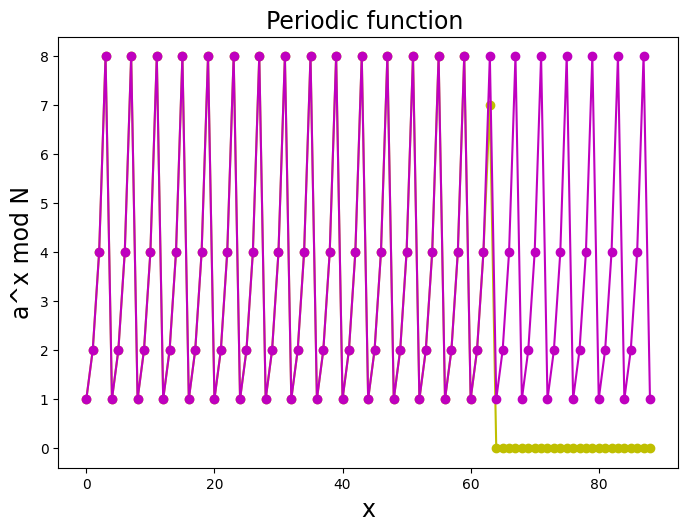

In [8]:
a = 2

N = 15

xmax = 6*N

f_mod_pow = np.array([])
for x in arange(0,xmax-1):
  f_pow = np.array([pow(a, int(x), N)])
  # print(f_pow)
  f_mod_pow = np.append(f_mod_pow,f_pow)

x = arange(0,xmax-1)
f_mod = mod(a**x,N)


#Plot
figsize = 8
plt.figure(figsize=(figsize,figsize*0.7))
ax = plt.gca()
plt.style.use('default')

ax.plot(x, f_mod,'o-y')
ax.plot(x, f_mod_pow,'o-m')

fs=17
plt.title('Periodic function ', fontsize=fs)
ax.set_ylabel(r'a^x mod N', fontsize=fs);
ax.set_xlabel(r'x', fontsize=fs);


# Classical FFT

Even though it is easy to see the period of this function plotted it is instructive to take the classical FFT and verify this period.

C:\Users\bobni\AppData\Local\Temp\ipykernel_19964\4111253861.py:8: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/f[:-1], np.abs(Y[:y_len-1])) #trim 1st data point


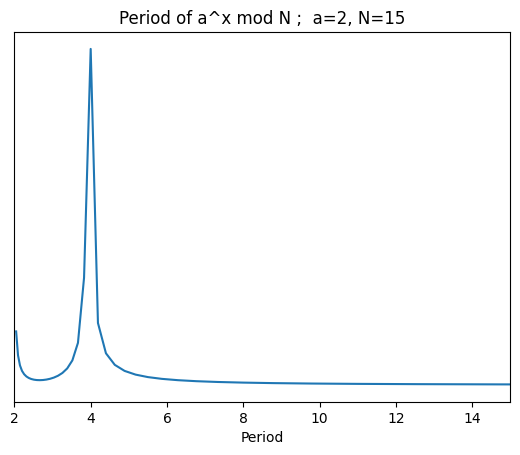

In [9]:
Y = np.fft.fft(f_mod_pow)

#Calculate frequency of FFT
y_len = int(len(Y)/2+1)
f = np.linspace(0, 1/2, y_len, endpoint=True)

#Plot 1/f = Period
plt.plot(1/f[:-1], np.abs(Y[:y_len-1])) #trim 1st data point
plt.xlabel('Period')
plt.title("Period of a^x mod N ;  a="+ str(a) + ", N="+ str(N))
yticks([])
xlim(2, N)
plt.show()

This period is quite short (just 4) but in practice would be very large.

To explore much larger sequences to look for periods we can use repeating squares:

In [10]:
a=2
N=15
j=7

power = np.array([])
a_squared = np.array([])

for i in range(0,j):
  power = np.append(power,2**i)
  a_squared = np.append(a_squared, a)
  print('i=',i, 'f_mod = mod(a ^ 2 ^',i,',N) = ',a, ' power = ',2**i)
  a = mod(a**2, N)


i= 0 f_mod = mod(a ^ 2 ^ 0 ,N) =  2  power =  1
i= 1 f_mod = mod(a ^ 2 ^ 1 ,N) =  4  power =  2
i= 2 f_mod = mod(a ^ 2 ^ 2 ,N) =  1  power =  4
i= 3 f_mod = mod(a ^ 2 ^ 3 ,N) =  1  power =  8
i= 4 f_mod = mod(a ^ 2 ^ 4 ,N) =  1  power =  16
i= 5 f_mod = mod(a ^ 2 ^ 5 ,N) =  1  power =  32
i= 6 f_mod = mod(a ^ 2 ^ 6 ,N) =  1  power =  64


This is interesting.

At some point the repeated squares hit '1', which was the original value of the qubit register, which shows the function is repeating.

So, then all of the subsequent squares just follow the same period of the initial squares and come back to '1'!

Plotting this out is very clear:

2
15
i= 0 f_mod = mod(a ^ 2 ^ 0 ,N) =  2  power =  1
i= 1 f_mod = mod(a ^ 2 ^ 1 ,N) =  4  power =  2
i= 2 f_mod = mod(a ^ 2 ^ 2 ,N) =  1  power =  4
i= 3 f_mod = mod(a ^ 2 ^ 3 ,N) =  1  power =  8
i= 4 f_mod = mod(a ^ 2 ^ 4 ,N) =  1  power =  16
i= 5 f_mod = mod(a ^ 2 ^ 5 ,N) =  1  power =  32
i= 6 f_mod = mod(a ^ 2 ^ 6 ,N) =  1  power =  64


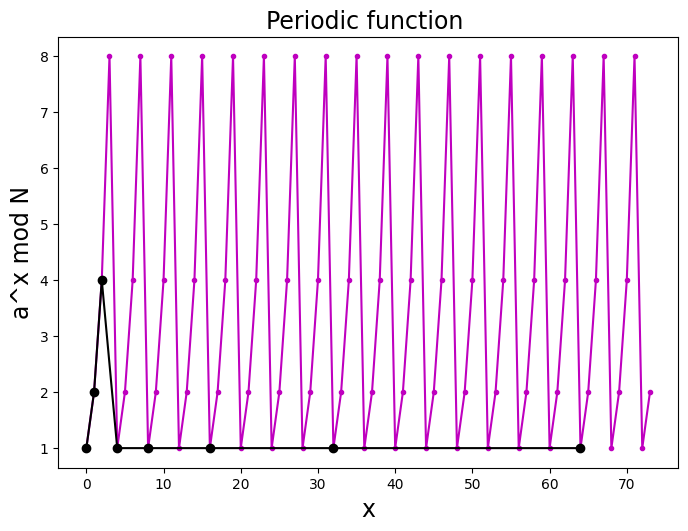

In [11]:
a = 2
print(a)
N = 15
print(N)

'''
Calculate all of the modular exponentiations
'''
xmax = 5*N
f_mod_pow = np.array([])
for x in arange(0,xmax-1):
  f_pow = np.array([pow(a, int(x), N)])
  # print(f_pow)
  f_mod_pow = np.append(f_mod_pow,f_pow)

x = arange(0,xmax-1)


'''
Repeated Squares
'''
j=7
power = np.array([])
a_squared = np.array([])
a_squared = np.append(a_squared, 1)
power = np.append(power,0)

for i in range(0,j):
  power = np.append(power,2**i)
  a_squared = np.append(a_squared, a)
  print('i=',i, 'f_mod = mod(a ^ 2 ^',i,',N) = ',a, ' power = ',2**i)
  a = mod(a**2, N)


#Plot
figsize = 8
plt.figure(figsize=(figsize,figsize*0.7))
ax = plt.gca()
plt.style.use('default')

ax.plot(x, f_mod_pow,'.-m')

ax.plot(power, a_squared,'o-k')


fs=17
plt.title('Periodic function ', fontsize=fs)
ax.set_ylabel(r'a^x mod N', fontsize=fs);
ax.set_xlabel(r'x', fontsize=fs);


# But how does the period give the factors of N?

So 'r' is the period when the function returns to 1 and therefore $a^r \text { mod } N = 1$

> In this case: $a^r = 2^4 = 16$,
> and $16 \text { mod }  15 = 1$

So $( a^r - 1 ) \text { mod } N = 0 $

So N must divide $( a^r - 1 )$ without a remainder.

If r is also even then $( a^r - 1 )$ has two factors:

$( a^r - 1 ) = (a^{r/2} - 1 )( a^{r/2} + 1 )$

$( 2^4 - 1 ) = (2^{2} - 1 )( 2^{2} + 1 ) = 15 = (3)(5)$

> if r is odd we must start over by picking a different 'a' and try again

So if N divides $( a^r - 1 )$ without a remainder and $( a^r - 1 )$ has factors $(a^{r/2} - 1 )$ and $( a^{r/2} + 1 )$ ...

then the greatest common denominator of N with either $(a^{r/2} - 1 )$ or $( a^{r/2} + 1 )$ is a factor of N.







# Eigenstate of U

A superposition of states in a single cycle is an eigenstate of the modular exponentiation!

That is if we setup a state

$|u_0⟩ = \frac{1}{\sqrt{4}} ( |1⟩ + |2⟩ + |4⟩ + |8⟩)$

$|u_0⟩ = \frac{1}{\sqrt{4}} ( |0001⟩ + |0010⟩ + |0100⟩ + |1000⟩)$

$|u_0⟩ = \frac{1}{\sqrt{4}} ( U|0001⟩ + U^2|0001⟩ + U^3|0001⟩ + U^4|0001⟩ )$

$|u_0⟩ = \frac{1}{\sqrt{r}} ∑ U^x |1⟩ $

$|u_0⟩ = \frac{1}{\sqrt{r}} ∑ |a^x \text{ mod } N⟩ $

When we apply the operator U everything just shifts and we get the same superpositions of states:

$U|y⟩ = | a \cdot y \text{ mod } N ⟩ $

$U|y⟩ = | 2 \cdot y \text{ mod } 15 ⟩ \\ $

$
U|0001⟩ = |0010⟩ \\
U|0010⟩ = |0100⟩ \\
U|0100⟩ = |1000⟩ \\
U|1000⟩ = |0001⟩ \\
$

so:

$U|u_0⟩ = |u_0⟩ $

This means that $|u_0⟩$ is an eigenvector of U, with an eigenvalue of 1.

---



## However, there are other eigenvectors of U.

Consider a construction that each basis state within the superposition statevector has a phase that is proportional to x such that:

## $|u_1⟩ = \frac{1}{\sqrt{r}} ∑ e^{\frac{-2 \pi i x}{r}} |a^x \text{ mod } N⟩ $

## $|u_1⟩ = \frac{1}{\sqrt{4}} ( |1⟩ + e^{\frac{-2 \pi i 1}{4}}|2⟩ + e^{\frac{-2 \pi i 2}{4}}|4⟩ + e^{\frac{-2 \pi i 3}{4}}|8⟩)$

Now applying U shifts the state register as before leaving the phase.

## $U |u_1⟩ = \frac{1}{\sqrt{4}} ( |2⟩ + e^{\frac{-2 \pi i 1}{4}}|4⟩ + e^{\frac{-2 \pi i 2}{4}}|8⟩ + e^{\frac{-2 \pi i 3}{4}}|1⟩)$

## $U |u_1⟩ = \frac{1}{\sqrt{4}}e^{\frac{2 \pi i}{4}} ( e^{\frac{-2 \pi i }{4}}|2⟩ + e^{\frac{-2 \pi i 2}{4}}|4⟩ + e^{\frac{-2 \pi i 3}{4}}|8⟩ + e^{\frac{-2 \pi i 4}{4}}|1⟩)$

## $U |u_1⟩ = \frac{1}{\sqrt{4}}e^{\frac{2 \pi i}{4}} ( e^{\frac{-2 \pi i }{4}}|2⟩ + e^{\frac{-2 \pi i 2}{4}}|4⟩ + e^{\frac{-2 \pi i 3}{4}}|8⟩ + |1⟩)$

## $U |u_1⟩ = \frac{1}{\sqrt{4}}e^{\frac{2 \pi i}{4}} ( |u_1⟩)$

Notice how the phase factor has the period 1/4 which is 1/r in it!
This is the period of the function and will give us the factors of N.

The problem is that we don't know $|u_1⟩$ ....

---------


# The Magic

What is surprising is that we just measure the phase of the trivially easy state to prepare '|1⟩' (aka |00001⟩ )  and get the phase factor with a denominator r without knowing eigenstate $|u_1⟩$

r is the periodicity of the function and will allow us to factor N.

But how can everything be measured through |1⟩?

First we can generalize $|u_1⟩$ for other multiples (besides s=1) for s up to r-1)

## $|u_s⟩ = \frac{1}{\sqrt{r}} ∑ e^{\frac{-2 \pi i x s}{r}} |a^x \text{ mod } N⟩ $

## $|u_s⟩ = \frac{1}{\sqrt{4}} ( |1⟩ + e^{\frac{-2 \pi i 1 s}{4}}|2⟩ + e^{\frac{-2 \pi i 2 s }{2}}|4⟩ + e^{\frac{-2 \pi i 3 s }{4}}|8⟩)$

## $U |u_s⟩ = \frac{1}{\sqrt{4}}e^{\frac{2 \pi i s}{4}} ( |u_1⟩)$

What is remarkable is that:

## $ \frac{1}{\sqrt{r}} ( |u_0⟩ + |u_1⟩ + |u_2⟩ + |u_3⟩)= |1⟩$

Writing it all out:

$\frac{1}{2}(~~|u_0⟩ = \frac{1}{\sqrt{4}} ( |1⟩ + |2⟩ + |4⟩ + |8⟩) ... \\$
$~~ + |u_1⟩ = \frac{1}{\sqrt{4}} ( |1⟩ + e^{\frac{-2 \pi i 1}{4}}|2⟩ + e^{\frac{-2 \pi i 2}{2}}|4⟩ + e^{\frac{-2 \pi i 3}{4}}|8⟩)...\\$
$~~ +|u_2⟩ = \frac{1}{\sqrt{4}} ( |1⟩ + e^{\frac{-2 \pi i 1  \cdot 2}{4}}|2⟩ + e^{\frac{-2 \pi i 4 }{2}}|4⟩ + e^{\frac{-2 \pi i 6 }{4}}|8⟩)...\\$
$~~ +|u_3⟩ = \frac{1}{\sqrt{4}} ( |1⟩ + e^{\frac{-2 \pi i 1  \cdot 3}{4}}|2⟩ + e^{\frac{-2 \pi i 6 }{2}}|4⟩ + e^{\frac{-2 \pi i 9 }{4}}|8⟩) ~~)= \\$
$~~~~ = |1⟩$

Checking the |2⟩ phase terms :

$ e^{0} + e^{\frac{-\pi i}{2}} + e^{- \pi i } + e^{\frac{-6 \pi i}{4}} =
1+i-1-i = 0 $

They all cancel out except |1⟩ !

-----

## Which means that we can do QPE on the function U just using the initial state |1⟩ (aka |0001⟩) because it is equivalent to testing all of the other eigenstates $|u_s⟩!$

So we just initilize the first bit in the register |1⟩ and we're ready to apply U!


#Back to the circuit

Ok, but how are we going to implement U?

$U|y⟩ = | 2\cdot y \text{ mod } 15 ⟩ $

Looking back at the cyclical nature of U we can see that U is just ***swapping*** the bit up the register (multiplying by 2...mod 15)

$U|0001⟩ = |0010⟩ \\
U|0010⟩ = |0100⟩ \\
U|0100⟩ = |1000⟩ \\
U|1000⟩ = |0001⟩ $

equivalent to:

$U(1) = 2 \\
U(2) = 4 \\
U(4) = 8 \\
U(8) = 1 $

So we can construct U from swaps.

## Controlled Swaps.

But how do we create a 'controlled swap'?

# U function

Below are a set of implementations of the circuit effectively creating a look up table for various values of a within the operator U.

We'll come back to this. For now let's skip over it and try to construct U from scratch.

In [12]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2,7,8,11 or 13")
    U = QuantumCircuit(4)
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

## Inverse QFT

In [13]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

Working it out again but with repeating squares:

$U = 2^x$ mod 15

$U |1⟩ = |2⟩$

$U^2 |1⟩ = |4⟩$

$U^4 |1⟩ = |1⟩$

$U^8 |1⟩ = |1⟩$

Repeating. With a period of 4 U's since $U^4$ returns back to the original value 1.

Writing out in binary:

$U |0001⟩ = |0010⟩$

$U^2 |0001⟩ = |0100⟩$

$U^4 |0001⟩ = |0001⟩$

Again , U is swapping the bit up the register.


## Control Swap

Similar to how a two qubit swap operation can be created from CNOTs, a 'control swap' can be created from CCNOTS (Toffoli Gates), as it requires a third qubit to act as the control.


In [14]:
def cswap():
    """Controlled swap"""
    U = QuantumCircuit(2)

    U.swap(0,1)

    U = U.to_gate()
    U.name = "cswap"
    c_U = U.control()
    return c_U

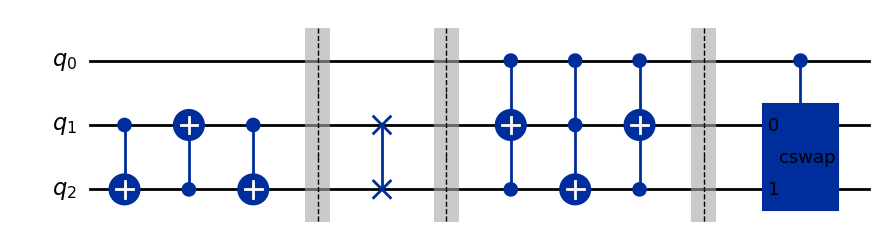

In [15]:
qc = QuantumCircuit(3)

qc.cx([1],[2])
qc.cx([2],[1])
qc.cx([1],[2])

qc.barrier()

qc.swap([1],[2])

qc.barrier()

qc.ccx([0],[2],[1])
qc.ccx([0],[1],[2])
qc.ccx([0],[2],[1])

qc.barrier()

qc.append(cswap(), [0,1,2])


qc.draw('mpl')

Above isn't a real circuit, it just shows each gate:

1. Swap of qubit 1 and qubit 2 (made from CNOT gates)

1. Swap of qubit 1 and qubit 2 (more compact notation)

1. Control Swap made of Toffoli gates

1. Control Swap of qubit 1 and qubit 2 based on qubit 0 (more compact notation)


# Phase estimation of a Control Swap

1. Initialize the control qubit in the |+⟩ state.

1. Initilize the x register into |1⟩ (|01⟩)

1. Control swap - equivalent to $U(y) = 2\cdot y$ mod 3

----

One note is that the input state is |1⟩ but in a notation where '1' represents the qubit string value. It is physically |0,0,0,1⟩. That is why there is one X gate before the U gates.

Why is |0,0,0,1⟩ the input? Recall that the periodic function of modular exponentiation returned to 1 and that we saw that the other superposition states all have phases that cancel out such that the sum is |1⟩!

<!-- Further, the amplitude of each equal superposition tells us how many states are in that superposition. Knowing the number of states is equivalent to knowing the period at which they return to 1.  -->

Therefore, measuring the phase of U, starting with |0,0,0,1⟩ is equivalent to knowing the period of U.

Period finding can then be used to factor N.



<!-- We get an entangled state that is equal parts swapped and not swapped!

What happened to the 'control' bit $q_0$? -->

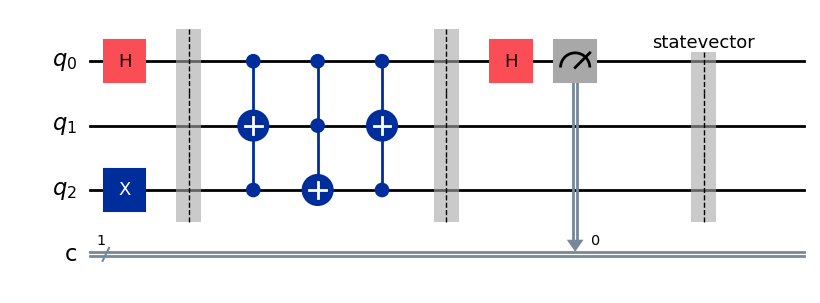

In [16]:
qc = QuantumCircuit(3,1)

qc.h(0)
qc.x(2)

qc.barrier()

qc.ccx([0],[2],[1])
qc.ccx([0],[1],[2])
qc.ccx([0],[2],[1])

qc.barrier()

qc.h(0)

qc.measure([0],[0])

qc.save_statevector()

qc.draw('mpl')

In [17]:
sim = QasmSimulator() #Set simulator to evolve state


In [18]:
# compiled_circuit = transpile(qc, sim) #Compile quantum circuit
# qc.save_statevector() #Save the state vector after simulation

'''
Run the simulation
'''
job = sim.run(qc)

#Plot final states on Bloch spheres
# bloch_sphere(job.result().get_statevector(qc))

statevector = job.result().get_statevector(qc)

In [19]:
statevector

Statevector([ 0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
              0.        +0.00000000e+00j, -0.70710678+8.65956056e-17j,
              0.        +0.00000000e+00j,  0.70710678+0.00000000e+00j,
              0.        +0.00000000e+00j,  0.        +0.00000000e+00j],
            dims=(2, 2, 2))


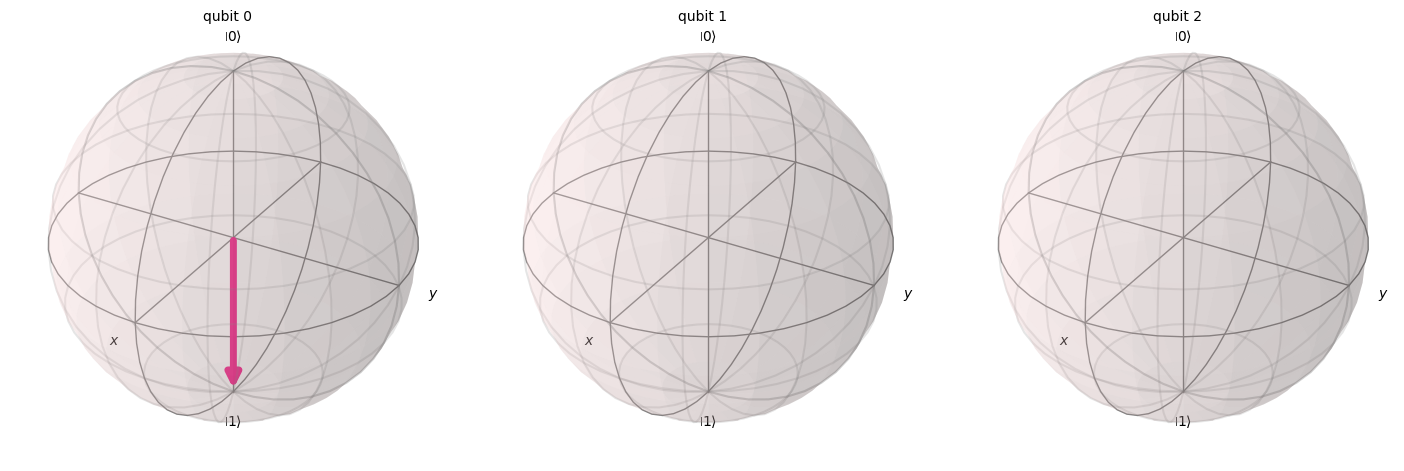

In [20]:
# statevector = Statevector().run(qc).result().get_statevector()
# from qiskit.primitives import Estimator

# print(statevector)
statevector.draw('latex')
plot_bloch_multivector(statevector)

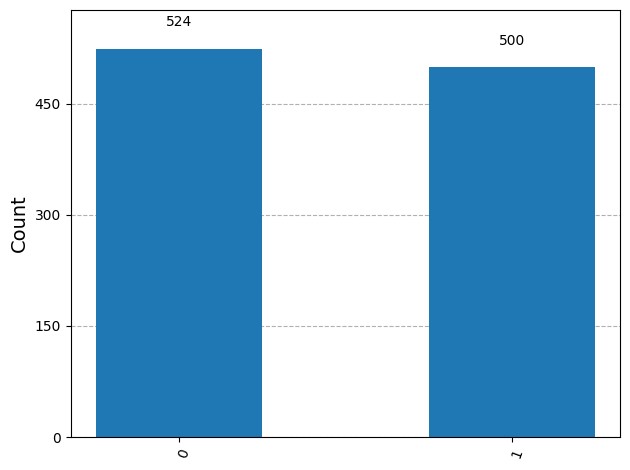

In [21]:
# aer_sim = Aer.get_backend('aer_simulator')
# t_qc = transpile(qc, aer_sim)
# qobj = assemble(t_qc)
results = sim.run(qc).result()
counts = results.get_counts()
plot_histogram(counts)

The measurement (QFT) qubit stays in a superposition state after the Control SWAPs with the lower register.

---

What happens if we swap it back?

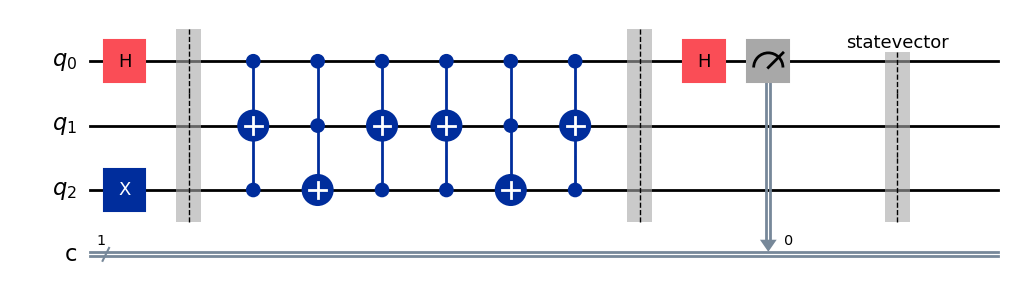

In [22]:
qc = QuantumCircuit(3,1)

qc.h(0)
qc.x(2)

qc.barrier()

qc.ccx([0],[2],[1])
qc.ccx([0],[1],[2])
qc.ccx([0],[2],[1])

qc.ccx([0],[2],[1])
qc.ccx([0],[1],[2])
qc.ccx([0],[2],[1])

qc.barrier()

qc.h(0)

qc.measure([0],[0])

qc.save_statevector()

qc.draw('mpl')

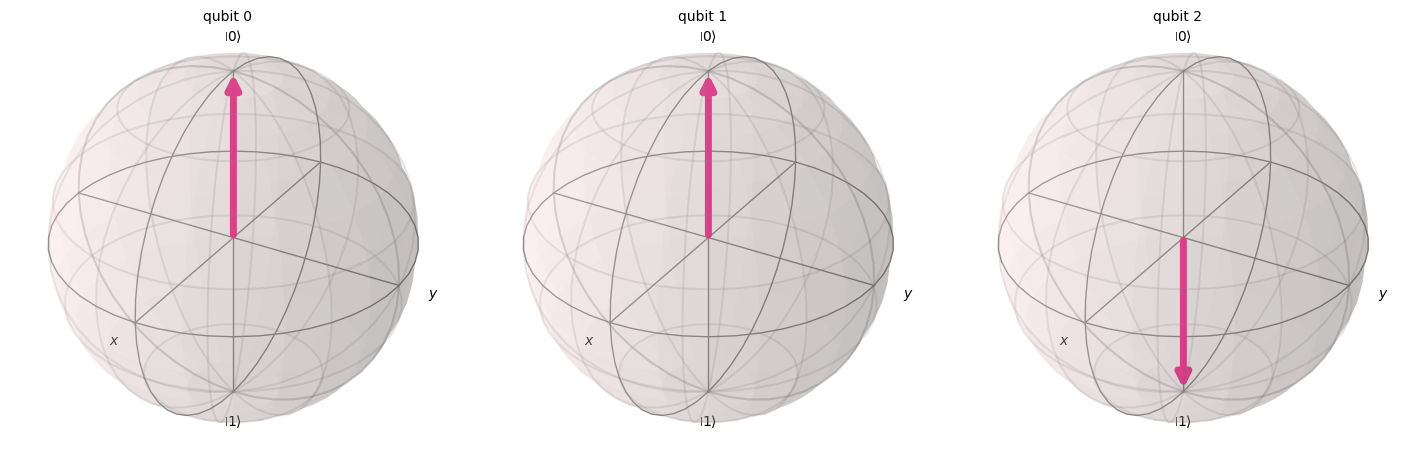

In [23]:
statevector = sim.run(qc).result().get_statevector()

# print(statevector)
statevector.draw('latex')
plot_bloch_multivector(statevector)

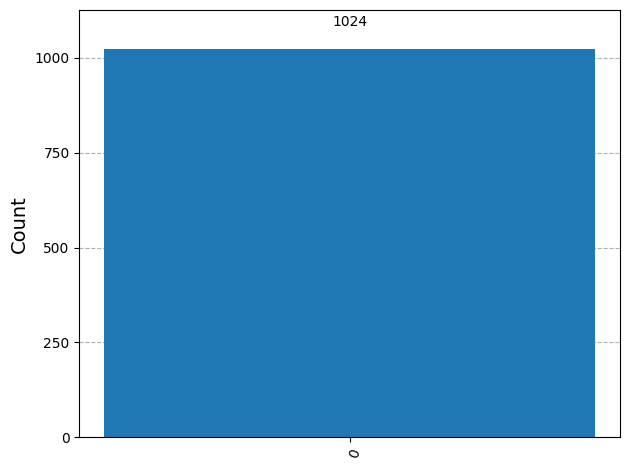

In [24]:
# aer_sim = Aer.get_backend('aer_simulator')
# t_qc = transpile(qc, aer_sim)
# qobj = assemble(t_qc)
results = sim.run(qc).result()
counts = results.get_counts()
plot_histogram(counts)

Now the 'QFT' qubit in the top register returns to 0 and the qubits in the bottom register become disentangled returning to their original states.

This shows that the (Control SWAP )$^2$ is periodic!

> $U^2(1) = 2^2 \cdot 1 \text{ mod } 3 = 1$

This is what we want to do with more sophisticated functions U, find when they are periodic. In this case the order was just 2.  Finding the order of U will allow us to factor N (because U is mod N).

Let's add some complexity.

## Ripple Swap

$U$ acting on two bits. Like a ripple swap.

Top register 1 = Phase estimation for QFT (n_phe_qubits, number of qubits sets precision of QFT and Phase estimation)

Bottom register 2 = input for U (n_U_qubits, length set by number of qubits needed to store operation and largest output, which because it is mod N, is just N)

If the bottom register 2 is in an eigenstate of U then the first circuit U will deliver a phase of $e^{iϕ}$ to the first qubit in the top register. Zero phase for |0⟩ but $e^{iϕ}$ for |1⟩.


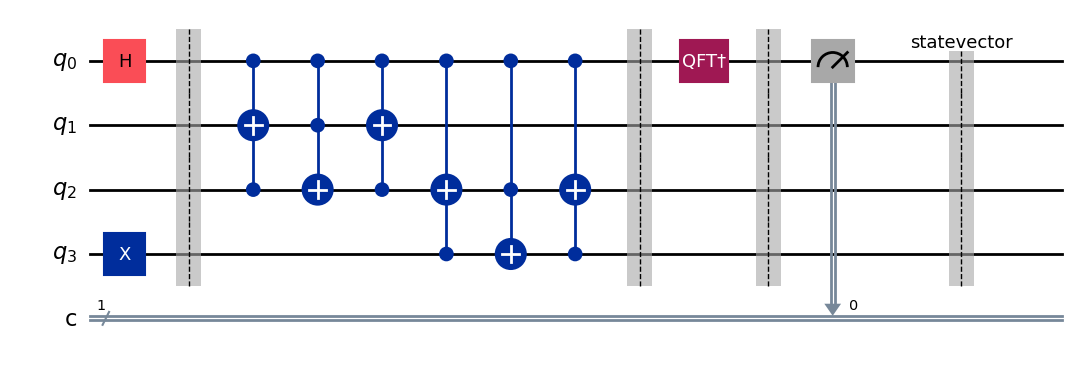

In [25]:
n_phe_qubits = 1
n_U_qubits = 3
n_qubits = n_phe_qubits+ n_U_qubits
qc = QuantumCircuit(n_qubits,n_phe_qubits)

for i in range(n_phe_qubits):
  qc.h(i)

qc.x(n_qubits-1)

qc.barrier()

qc.ccx([0],[n_phe_qubits+1],[n_phe_qubits])
qc.ccx([0],[n_phe_qubits],[n_phe_qubits+1])
qc.ccx([0],[n_phe_qubits+1],[n_phe_qubits])

qc.ccx([0],[n_phe_qubits+2],[n_phe_qubits+1])
qc.ccx([0],[n_phe_qubits+1],[n_phe_qubits+2])
qc.ccx([0],[n_phe_qubits+2],[n_phe_qubits+1])

qc.barrier()

qc.append(qft_dagger(n_phe_qubits), range(n_phe_qubits))

qc.barrier()

qc.measure( range(n_phe_qubits), range(n_phe_qubits))

qc.save_statevector()

qc.draw('mpl')

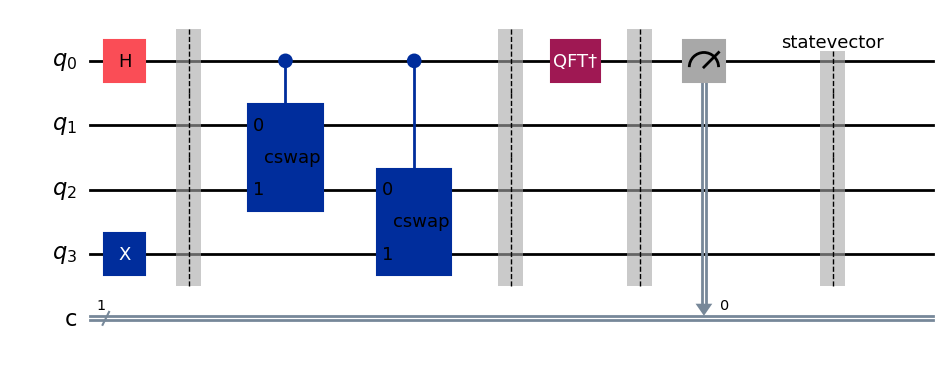

In [26]:
n_phe_qubits = 1
n_U_qubits = 3
n_qubits = n_phe_qubits+ n_U_qubits
qc = QuantumCircuit(n_qubits,n_phe_qubits)

for i in range(n_phe_qubits):
  qc.h(i)

qc.x(n_qubits-1)

qc.barrier()

qc.append(cswap(), [0,n_phe_qubits,n_phe_qubits+1])
qc.append(cswap(), [0,n_phe_qubits+1,n_phe_qubits+2])

qc.barrier()

qc.append(qft_dagger(n_phe_qubits), range(n_phe_qubits))

qc.barrier()

qc.measure( range(n_phe_qubits), range(n_phe_qubits))

qc.save_statevector()

qc.draw('mpl')

## U and U repeated squares

The second section of control swaps is just the first circuit squared.

So it will deliver twice the phase , $e^{2\cdot iϕ}$ and so on each squared circuit will deliver twice the phase of the previous, to a different qubit in the phase estimation top register.

Directly writing the phase $\phi$ into the phase basis just like we had for manually writing the phase before extracting it with the QFT.


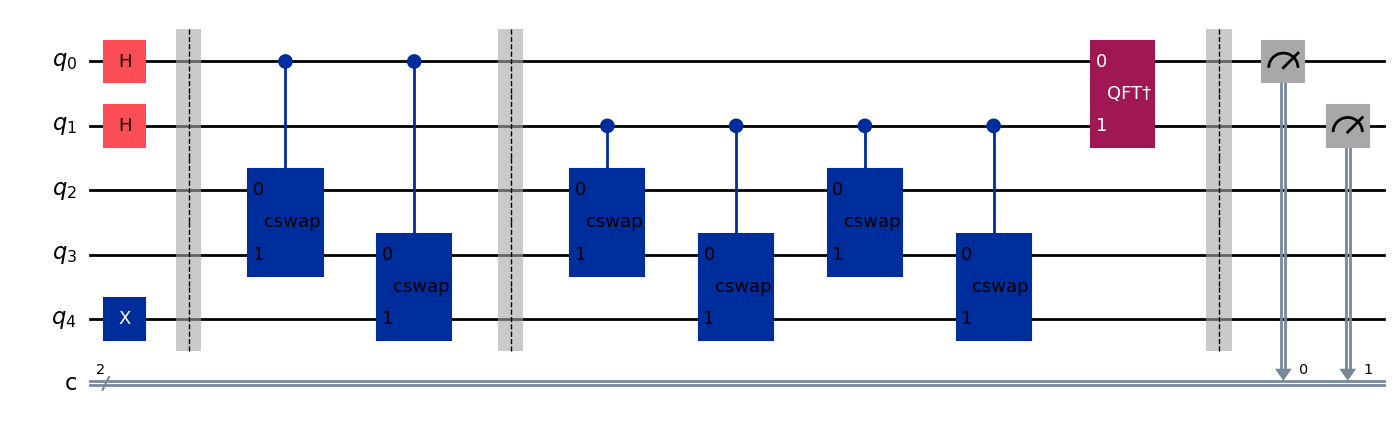

In [27]:
n_phe_qubits = 2
n_U_qubits = 3
n_qubits = n_phe_qubits+ n_U_qubits
qc = QuantumCircuit(n_qubits,n_phe_qubits)

for i in range(n_phe_qubits):
  qc.h(i)

qc.x(n_qubits-1)

qc.barrier()

qc.append(cswap(), [0,n_phe_qubits,n_phe_qubits+1])
qc.append(cswap(), [0,n_phe_qubits+1,n_phe_qubits+2])


qc.barrier()

qc.append(cswap(), [1,n_phe_qubits,n_phe_qubits+1])
qc.append(cswap(), [1,n_phe_qubits+1,n_phe_qubits+2])


qc.append(cswap(), [1,n_phe_qubits,n_phe_qubits+1])
qc.append(cswap(), [1,n_phe_qubits+1,n_phe_qubits+2])

qc.append(qft_dagger(n_phe_qubits), range(n_phe_qubits))

qc.barrier()

qc.measure(range(n_phe_qubits), range(n_phe_qubits))

# qc.save_statevector()

qc.draw('mpl')

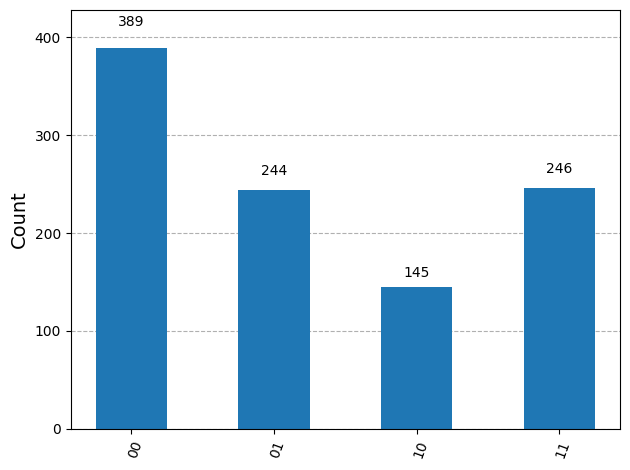

In [28]:
# backend = Aer.get_backend('qasm_simulator')

# # Simulate algorithm
# n_shots = 1024
# job_sim = execute(qc, backend, shots=n_shots)
# result_sim = job_sim.result()
# counts = result_sim.get_counts(qc)

# # Plot results
# plot_histogram(counts)

results = sim.run(qc.decompose(reps=6)).result()
counts = results.get_counts()
plot_histogram(counts)

#Estimate r from phase

With these measurements of the phase $ϕ$ from the quantum phase estimation we can guess r.

$ϕ = \frac{s}{r}$

In [29]:
n_count = n_phe_qubits

rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**n_count)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{decimal}/{2**n_count} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

      Register Output       Phase
0  10(bin) =   2(dec)  2/4 = 0.50
1  11(bin) =   3(dec)  3/4 = 0.75
2  00(bin) =   0(dec)  0/4 = 0.00
3  01(bin) =   1(dec)  1/4 = 0.25


In [30]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, f"{frac.numerator}/{frac.denominator}", frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.50      1/2            2
1   0.75      3/4            4
2   0.00      0/1            1
3   0.25      1/4            4


From r we can guess factors of N

r-1 and r+1

3 × 5 = 15

Success!

Not bad... but those were really the only permutations of those bits possible...We'll need more to convince ourselves the algorithm is working.

Also the function is not yet periodic.

$U^2$ does not return the qubits to their original state. We must test $U^4$.

#Shor from scratch

Add one more bit to the phase estimation register and one more bit to the U register so that it can fit N entirely.

We now have $U$, $U^2$, $U^4$.


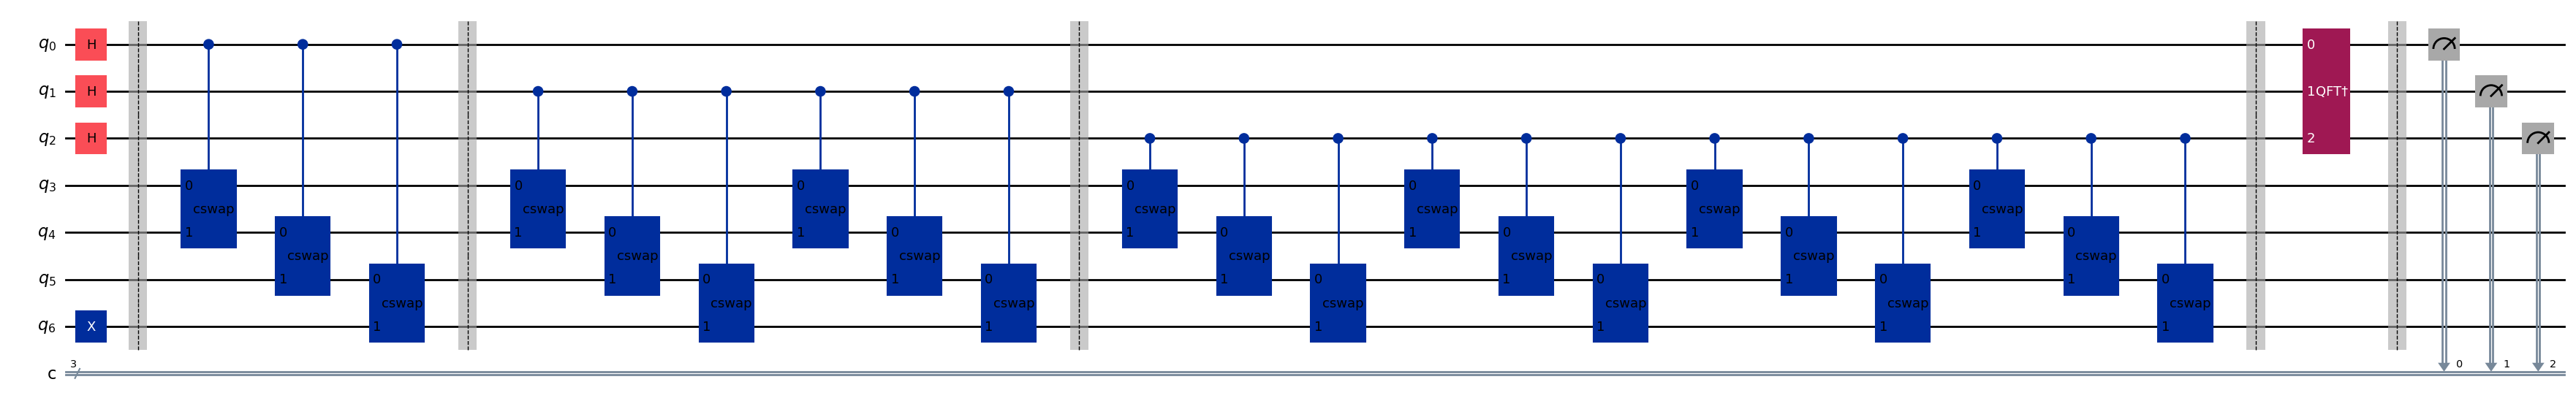

In [140]:
n_phe_qubits = 3
n_U_qubits = 4
n_qubits = n_phe_qubits+ n_U_qubits
qc = QuantumCircuit(n_qubits,n_phe_qubits)

for i in range(n_phe_qubits):
  qc.h(i)

qc.x(n_qubits-1)

qc.barrier()

'''
U^1
'''
qc.append(cswap(), [0,n_phe_qubits,n_phe_qubits+1])
qc.append(cswap(), [0,n_phe_qubits+1,n_phe_qubits+2])
qc.append(cswap(), [0,n_phe_qubits+2,n_phe_qubits+3])

qc.barrier()

'''
U^2
'''
qc.append(cswap(), [1,n_phe_qubits,n_phe_qubits+1])
qc.append(cswap(), [1,n_phe_qubits+1,n_phe_qubits+2])
qc.append(cswap(), [1,n_phe_qubits+2,n_phe_qubits+3])

qc.append(cswap(), [1,n_phe_qubits,n_phe_qubits+1])
qc.append(cswap(), [1,n_phe_qubits+1,n_phe_qubits+2])
qc.append(cswap(), [1,n_phe_qubits+2,n_phe_qubits+3])

qc.barrier()
'''
U^4
'''

for i in range(4):
  qc.append(cswap(), [2,n_phe_qubits,n_phe_qubits+1])
  qc.append(cswap(), [2,n_phe_qubits+1,n_phe_qubits+2])
  qc.append(cswap(), [2,n_phe_qubits+2,n_phe_qubits+3])

qc.barrier()

'''
QFT
'''
qc.append(qft_dagger(n_phe_qubits), range(n_phe_qubits))

qc.barrier()

qc.measure(range(n_phe_qubits), range(n_phe_qubits))

# qc.save_statevector()

qc.draw('mpl',fold=70)

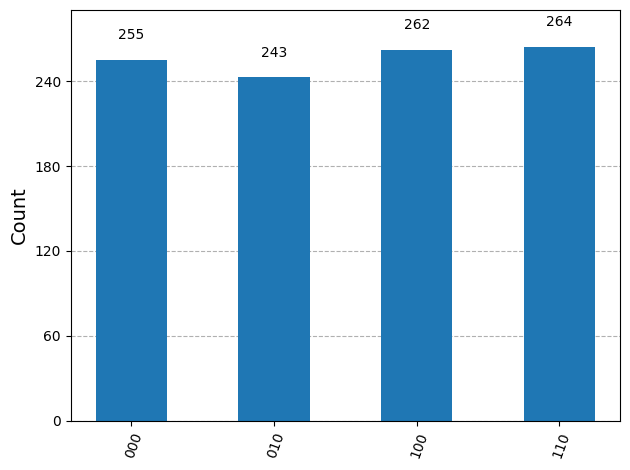

In [32]:
# backend = Aer.get_backend('qasm_simulator')

# # Simulate algorithm
# n_shots = 1024
# job_sim = execute(qc, backend, shots=n_shots)
# result_sim = job_sim.result()
# counts = result_sim.get_counts(qc)

# # Plot results
# plot_histogram(counts)

results = sim.run(qc.decompose(reps=6)).result()
counts = results.get_counts()
plot_histogram(counts)

One more bit of precision but we're effectively getting the same answer!

In [33]:
rows, measured_phases = [], []
n_count = n_phe_qubits
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**n_count)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{decimal}/{2**n_count} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

       Register Output       Phase
0  010(bin) =   2(dec)  2/8 = 0.25
1  100(bin) =   4(dec)  4/8 = 0.50
2  000(bin) =   0(dec)  0/8 = 0.00
3  110(bin) =   6(dec)  6/8 = 0.75


In [34]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, f"{frac.numerator}/{frac.denominator}", frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.25      1/4            4
1   0.50      1/2            2
2   0.00      0/1            1
3   0.75      3/4            4


Let's double check what the phases were doing:

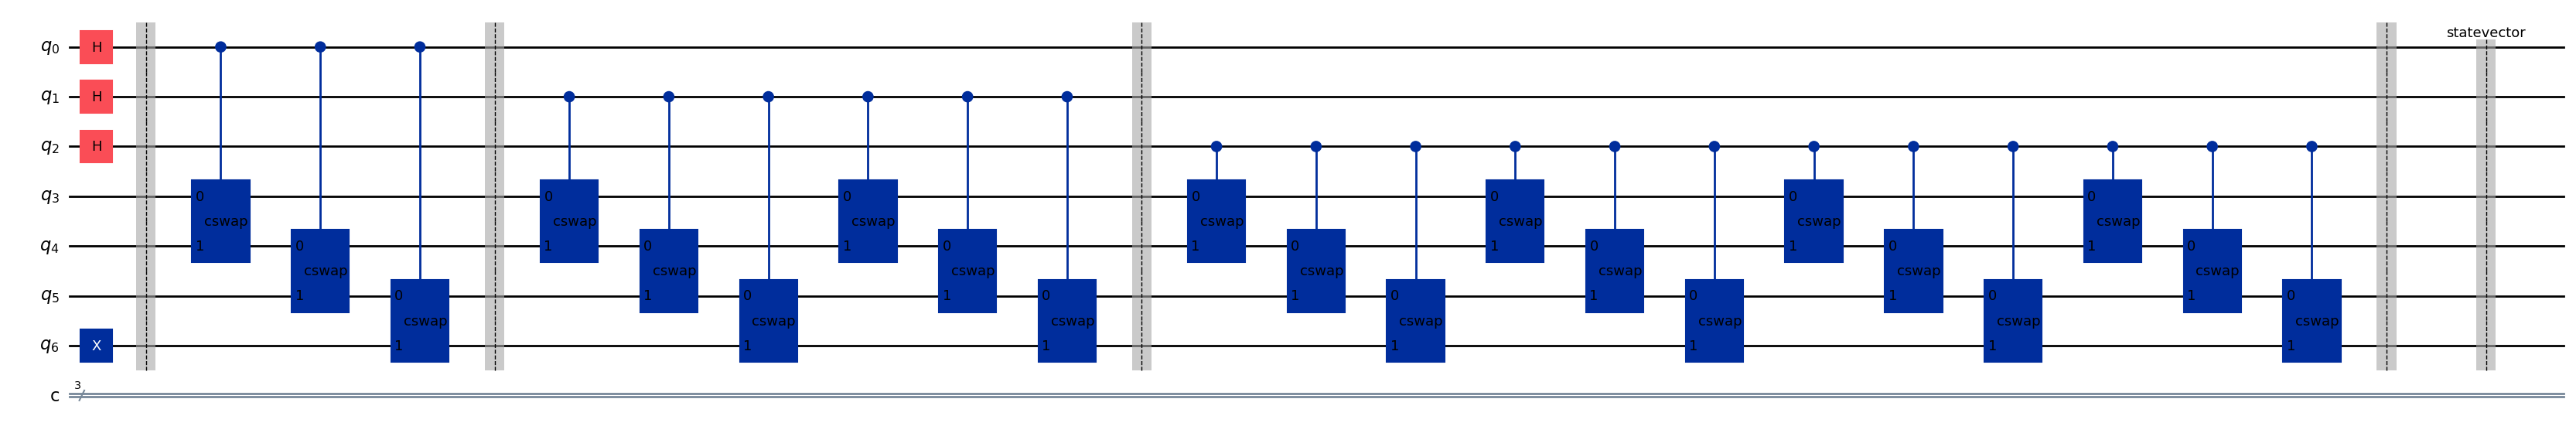

In [35]:
n_phe_qubits = 3
n_U_qubits = 4
n_qubits = n_phe_qubits+ n_U_qubits
qc = QuantumCircuit(n_qubits,n_phe_qubits)

for i in range(n_phe_qubits):
  qc.h(i)

qc.x(n_qubits-1)

qc.barrier()

'''
U^1
'''
qc.append(cswap(), [0,n_phe_qubits,n_phe_qubits+1])
qc.append(cswap(), [0,n_phe_qubits+1,n_phe_qubits+2])
qc.append(cswap(), [0,n_phe_qubits+2,n_phe_qubits+3])

qc.barrier()

'''
U^2
'''
qc.append(cswap(), [1,n_phe_qubits,n_phe_qubits+1])
qc.append(cswap(), [1,n_phe_qubits+1,n_phe_qubits+2])
qc.append(cswap(), [1,n_phe_qubits+2,n_phe_qubits+3])

qc.append(cswap(), [1,n_phe_qubits,n_phe_qubits+1])
qc.append(cswap(), [1,n_phe_qubits+1,n_phe_qubits+2])
qc.append(cswap(), [1,n_phe_qubits+2,n_phe_qubits+3])

qc.barrier()
'''
U^4
'''

for i in range(4):
  qc.append(cswap(), [2,n_phe_qubits,n_phe_qubits+1])
  qc.append(cswap(), [2,n_phe_qubits+1,n_phe_qubits+2])
  qc.append(cswap(), [2,n_phe_qubits+2,n_phe_qubits+3])

qc.barrier()

'''
QFT
'''
# qc.append(qft_dagger(n_phe_qubits), range(n_phe_qubits))

# qc.barrier()

# qc.measure(range(n_phe_qubits), range(n_phe_qubits))

qc.save_statevector()

qc.draw('mpl', fold = 50)

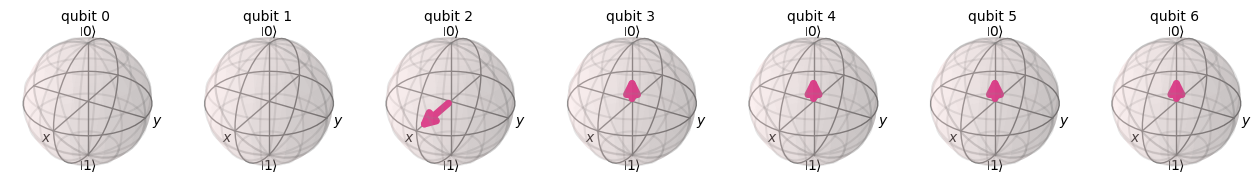

In [36]:
'''Simulate Statevector'''
job_sim = sim.run(qc.decompose(), shots=1)
plot_bloch_multivector(job_sim.result().get_statevector())

Looking at just the QPE qubits (qubit 0,1,2), we see that qubit 2 has returned to the |+⟩ state!

This means the phase kickbacks it recieved with the lower register were all 'undone' making them periodic!



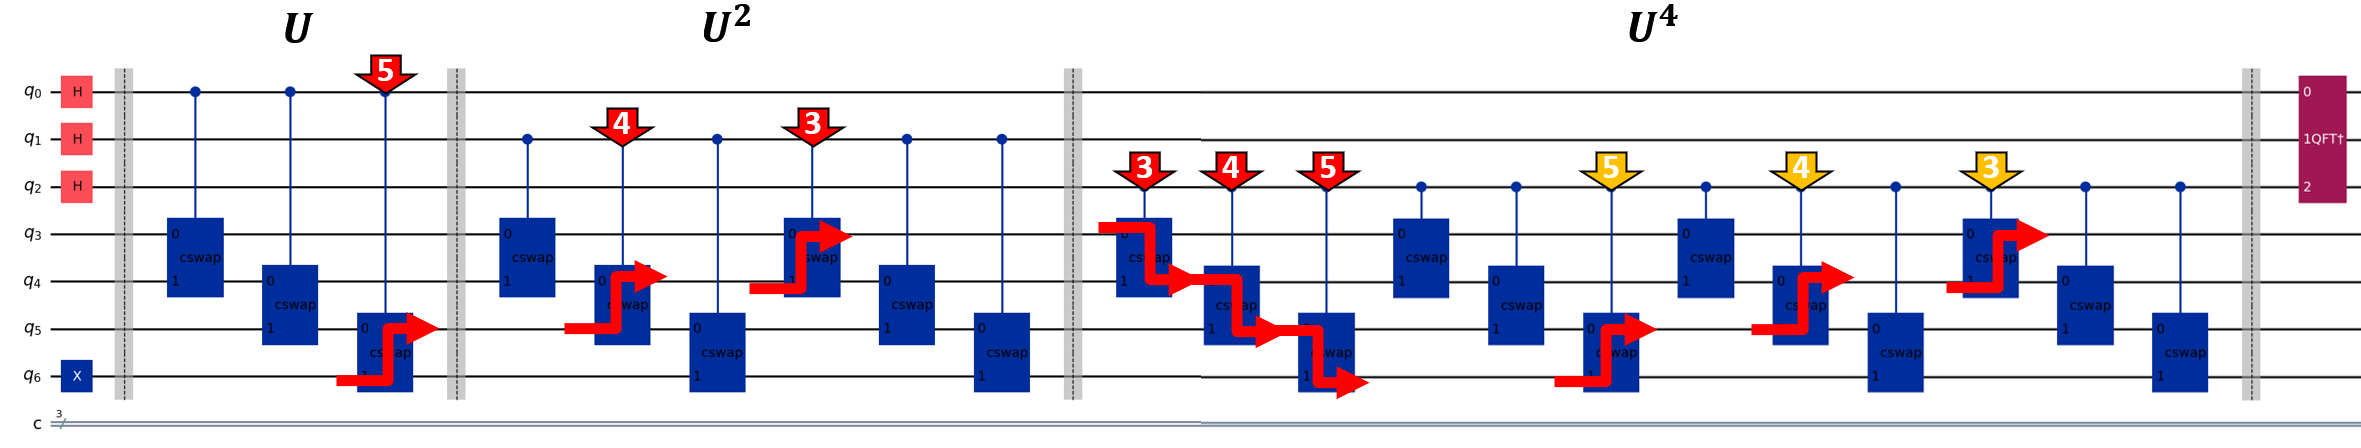

## More Shor (bits)


----


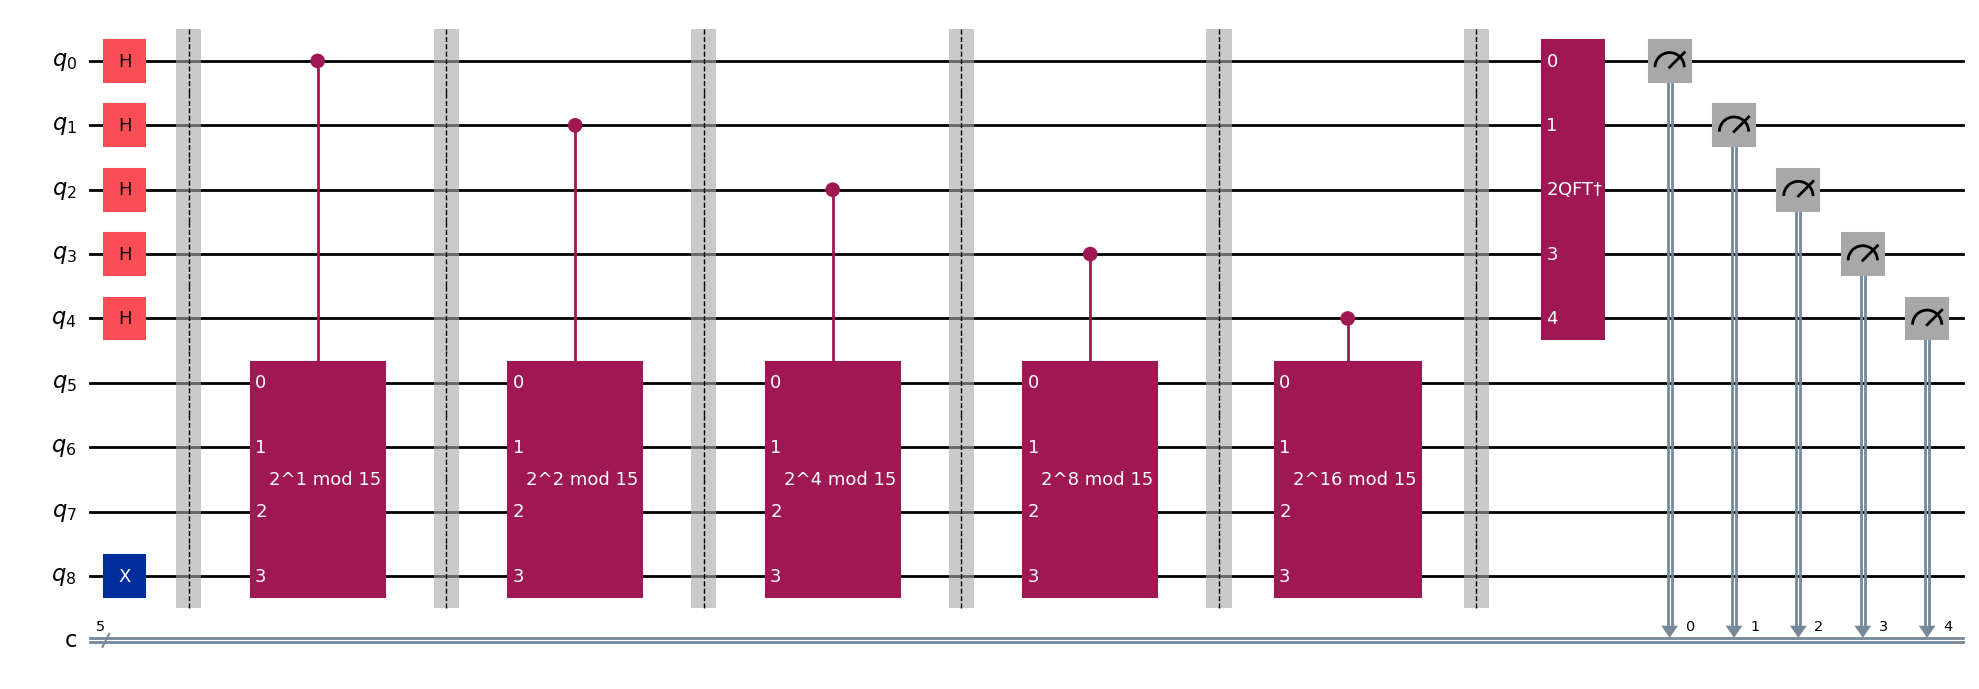

In [37]:
n_count = 5
a = 2

qc = QuantumCircuit(n_count + 4, n_count)

for q in range(n_count):
    qc.h(q)

qc.x(3+n_count)

qc.barrier()

for q in range(n_count):
    qc.append(c_amod15(a, 2**q),
             [q] + [i+n_count for i in range(4)])
    qc.barrier()

qc.append(qft_dagger(n_count), range(n_count))

qc.measure(range(n_count), range(n_count))
qc.draw('mpl',fold=100)


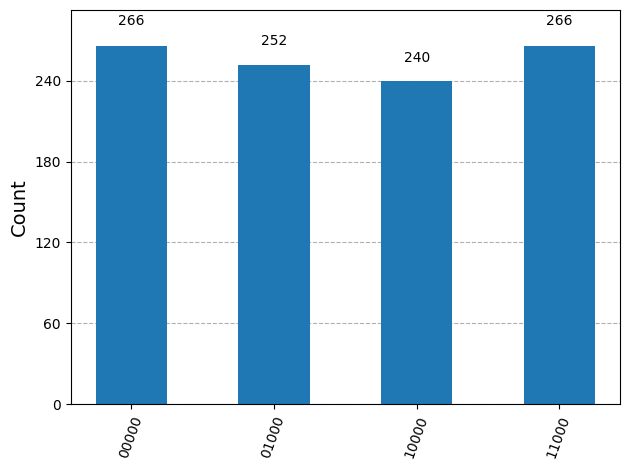

In [38]:
results = sim.run(qc.decompose(reps=6)).result()
counts = results.get_counts()
plot_histogram(counts)

In [39]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**n_count)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{decimal}/{2**n_count} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

         Register Output         Phase
0  01000(bin) =   8(dec)   8/32 = 0.25
1  00000(bin) =   0(dec)   0/32 = 0.00
2  10000(bin) =  16(dec)  16/32 = 0.50
3  11000(bin) =  24(dec)  24/32 = 0.75


In [40]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, f"{frac.numerator}/{frac.denominator}", frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.25      1/4            4
1   0.00      0/1            1
2   0.50      1/2            2
3   0.75      3/4            4


Adding more bits of precision in our QPE has not given different results.

This is due to the periodic nature of the function. Once it is repeating, it doesn't add any more phase to the QFT.

#But how does the phase give the factors of N?


Once we have the phase we have guesses for 'r'.

If r is the period when the function returns to 1 then $a^r \text { mod } N = 1$

Then $( a^r - 1 ) \text { mod } N = 0 $

So N must divide $( a^r - 1 )$ without a remainder.

If r is also even then $( a^r - 1 )$ has two factors:

$( a^r - 1 ) = (a^{r/2} - 1 )( a^{r/2} + 1 )$

> if r is odd we must start over by picking a different 'a' and try again

So if N divides $( a^r - 1 )$ without a remainder and $( a^r - 1 )$ has factors $(a^{r/2} - 1 )$ and $( a^{r/2} + 1 )$ ...

then the greatest common denominator of N with either $(a^{r/2} - 1 )$ or $( a^{r/2} + 1 )$ is a factor of N.







In [41]:
def qpe_amod15(a):
    n_count = 8
    qc = QuantumCircuit(4+n_count, n_count)
    for q in range(n_count):
        qc.h(q)
    qc.x(3+n_count)
    for q in range(n_count):
        qc.append(c_amod15(a, 2**q),
                 [q] + [i+n_count for i in range(4)])
    qc.append(qft_dagger(n_count), range(n_count))
    qc.measure(range(n_count), range(n_count))

    results = sim.run(qc.decompose(reps=1), memory=True, shots=1).result()
    readings = results.get_memory()

    print("Register Reading: " + readings[0])
    phase = int(readings[0],2)/(2**n_count)
    print("Corresponding Phase: %f" % phase)
    return phase

In [42]:
phase = qpe_amod15(a) # Phase = s/r
Fraction(phase).limit_denominator(15) # Denominator should (hopefully!) tell us r

Register Reading: 11000000
Corresponding Phase: 0.750000


Fraction(3, 4)

In [43]:
frac = Fraction(phase).limit_denominator(15)
s, r = frac.numerator, frac.denominator
print(r)

4


In [44]:
guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]

print(np.round(guesses))

[3 5]


# Draper Adder

Drapper Adder for U

In [48]:
p = 3
q = 5
N = p*q

print('N=',N)

n = N.bit_length()
print('bit length n = ',n)

print('p binary =' , format(p,"b"))
print('q binary =' , format(q,"b"))

N= 15
bit length n =  4
p binary = 11
q binary = 101


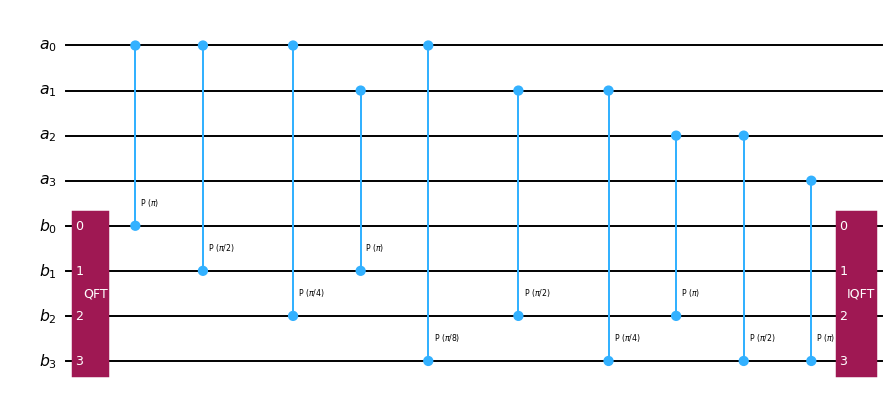

In [46]:
from qiskit.circuit.library import DraperQFTAdder
gate = DraperQFTAdder(4)
gate.decompose().draw('mpl',scale=0.7,fold=50)

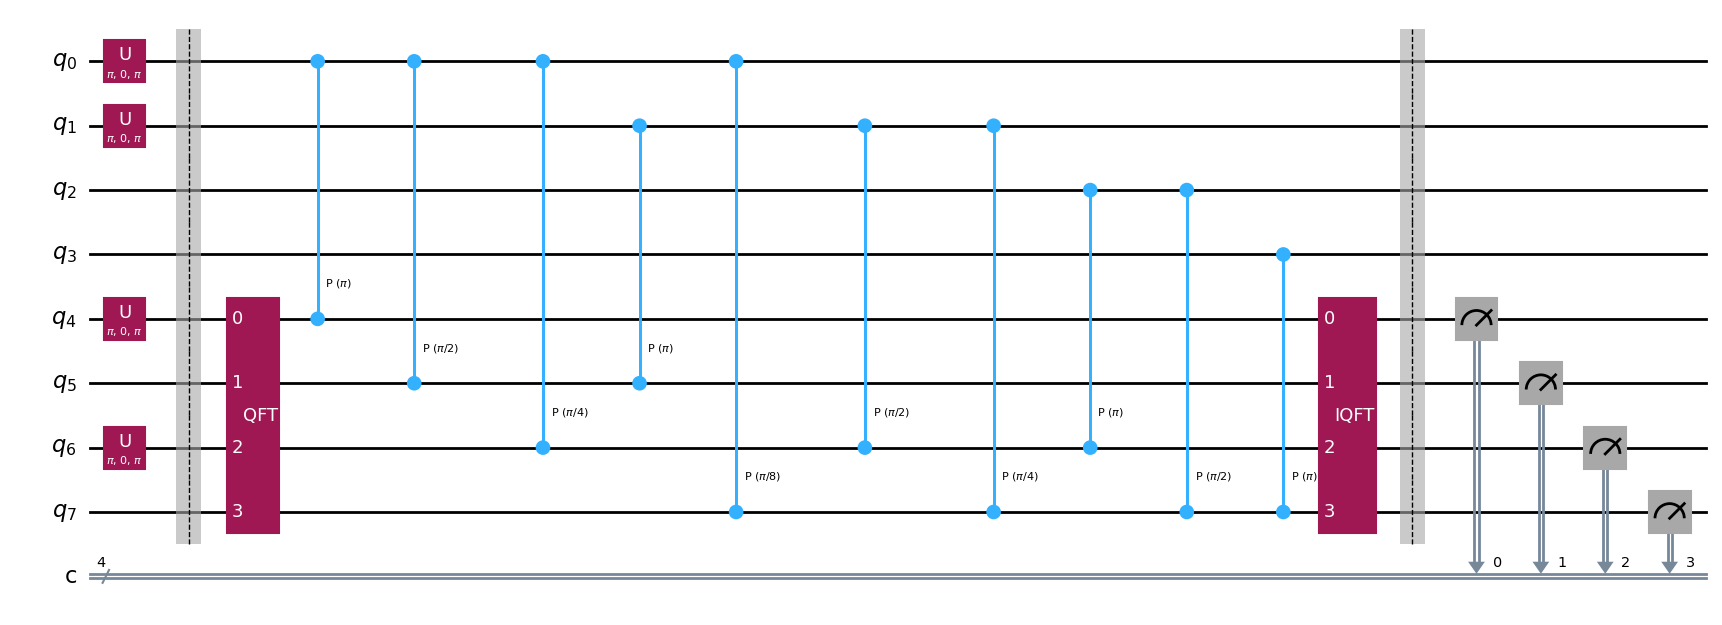

In [61]:
qc = QuantumCircuit(2*n,n)

'''Initialize 3'''
qc.x(0)
qc.x(1)

'''Initialize 5'''
qc.x(4)
qc.x(6)

qc.barrier()

qc.append(DraperQFTAdder(n), range(2*n))

qc.barrier()

qc.measure([4,5,6,7], range(n))


qc.decompose(reps=2).draw('mpl')


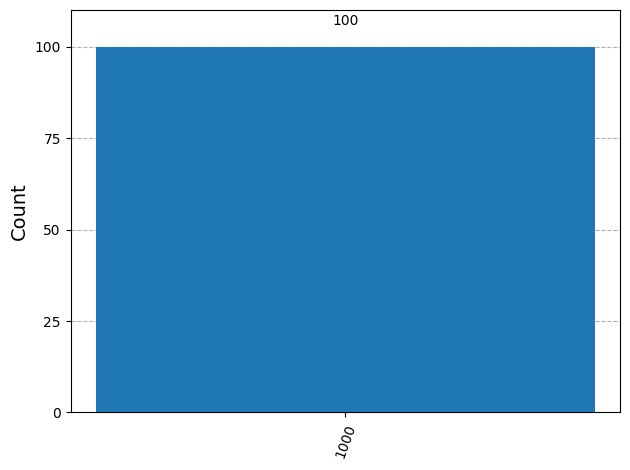

bit string= 1000
Answer= 8


In [57]:
results = sim.run(qc.decompose(reps=6),shots=100).result()
counts = results.get_counts()
display(plot_histogram(counts))

frequent = counts.most_frequent()
print('bit string=',frequent)
print('Answer=',int(frequent,2))


## Larger N

55
[  0  20  40  60  80 100 120 140 160]


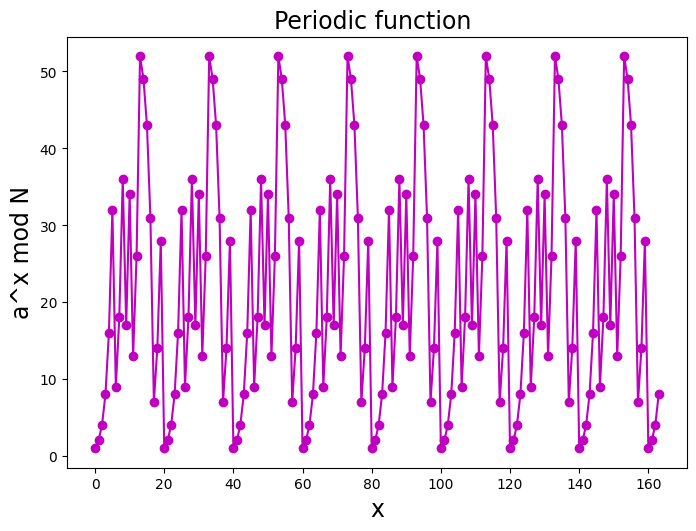

In [6]:
p = 5
q = 11
N = p*q


a = 2

print(N)

xmax = 3*N
# xmax = 50

f_mod_pow = np.array([])
for x in arange(0,xmax-1):
  f_pow = np.array([pow(a, int(x), N)])
  # print(f_pow)
  f_mod_pow = np.append(f_mod_pow,f_pow)

x = arange(0,xmax-1)

#Plot
figsize = 8
plt.figure(figsize=(figsize,figsize*0.7))
ax = plt.gca()
plt.style.use('default')

ax.plot(x, (f_mod_pow),'o-m')

fs=17
plt.title('Periodic function ', fontsize=fs)
ax.set_ylabel(r'a^x mod N', fontsize=fs);
ax.set_xlabel(r'x', fontsize=fs);

print(np.where(f_mod_pow == 1)[0])

In [7]:
print('N=',N)

r = int(np.where(f_mod_pow == 1)[0][1])

print('r=',r)

print('a**(r//2)-1=', a**(r//2)-1 )
print('a**(r//2)+1=', a**(r//2)+1 )

print( 'mod(a**(r//2)-1,N)=', mod(a**(r//2)-1,N) )
print( 'mod(a**(r//2)+1,N)=', mod(a**(r//2)+1,N) )

guesses = [gcd(mod(a**(r//2)-1,N), N), gcd(mod(a**(r//2)+1,N), N)]

print('guesses',guesses)

N= 55
r= 20
a**(r//2)-1= 1023
a**(r//2)+1= 1025
mod(a**(r//2)-1,N)= 33
mod(a**(r//2)+1,N)= 35
guesses [np.int64(11), np.int64(5)]


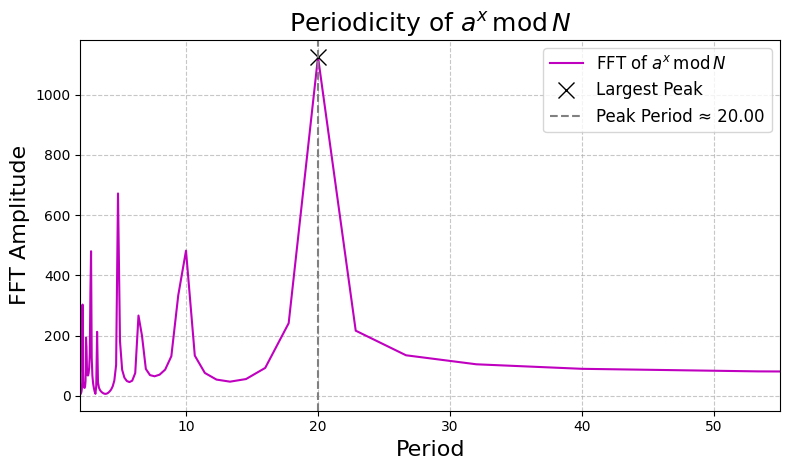

Largest peak period: 20.00


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# FFT
Y = np.fft.fft(f_mod_pow)

# Calculate frequency and period
y_len = int(len(Y)//2 - 1)
f = np.linspace(0, 1/2, y_len, endpoint=True)
period = 1 / f[1:-1]
yFFT = np.abs(Y[1:y_len-1])

# Find all peaks
peaks, _ = find_peaks(yFFT)

# Find the largest peak
largest_peak_idx = peaks[np.argmax(yFFT[peaks])]
largest_peak_period = period[largest_peak_idx]

# Plot
figsize = 8
plt.figure(figsize=(figsize, figsize * 0.6))
plt.style.use('default')
ax = plt.gca()

ax.plot(period, yFFT, '-m', label=r'FFT of $a^x \,\mathrm{mod}\, N$')
ax.plot(period[largest_peak_idx], yFFT[largest_peak_idx], 'xk', markersize=12, label='Largest Peak')

# Vertical line at largest peak
ax.axvline(largest_peak_period, color='gray', linestyle='--', label=f'Peak Period ≈ {largest_peak_period:.2f}')

# Labels and formatting
fs = 16
ax.set_xlabel('Period', fontsize=fs)
ax.set_ylabel('FFT Amplitude', fontsize=fs)
ax.set_title(r'Periodicity of $a^x \,\mathrm{mod}\, N$', fontsize=fs+2)
ax.set_xlim(2, N)
ax.grid(True, which="both", ls="--", alpha=0.7)
ax.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Print largest peak period
print(f"Largest peak period: {largest_peak_period:.2f}")


2
55
i= 0 f_mod = mod(a ^ 2 ^ 0 ,N) =  2  power =  1
i= 1 f_mod = mod(a ^ 2 ^ 1 ,N) =  4  power =  2
i= 2 f_mod = mod(a ^ 2 ^ 2 ,N) =  16  power =  4
i= 3 f_mod = mod(a ^ 2 ^ 3 ,N) =  36  power =  8
i= 4 f_mod = mod(a ^ 2 ^ 4 ,N) =  31  power =  16
i= 5 f_mod = mod(a ^ 2 ^ 5 ,N) =  26  power =  32
i= 6 f_mod = mod(a ^ 2 ^ 6 ,N) =  16  power =  64
i= 7 f_mod = mod(a ^ 2 ^ 7 ,N) =  36  power =  128
i= 8 f_mod = mod(a ^ 2 ^ 8 ,N) =  31  power =  256
i= 9 f_mod = mod(a ^ 2 ^ 9 ,N) =  26  power =  512
i= 10 f_mod = mod(a ^ 2 ^ 10 ,N) =  16  power =  1024
i= 11 f_mod = mod(a ^ 2 ^ 11 ,N) =  36  power =  2048
i= 12 f_mod = mod(a ^ 2 ^ 12 ,N) =  31  power =  4096
i= 13 f_mod = mod(a ^ 2 ^ 13 ,N) =  26  power =  8192
i= 14 f_mod = mod(a ^ 2 ^ 14 ,N) =  16  power =  16384
i= 15 f_mod = mod(a ^ 2 ^ 15 ,N) =  36  power =  32768
i= 16 f_mod = mod(a ^ 2 ^ 16 ,N) =  31  power =  65536
i= 17 f_mod = mod(a ^ 2 ^ 17 ,N) =  26  power =  131072
i= 18 f_mod = mod(a ^ 2 ^ 18 ,N) =  16  power =  262144
i= 19

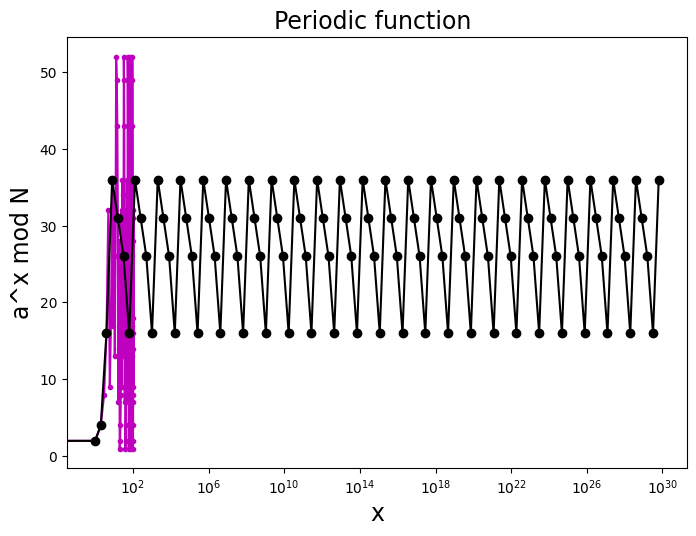

In [9]:
print(a)
print(N)

'''
Calculate all of the modular exponentiations
'''
xmax = int(2*N)
f_mod_pow = np.array([])
for x in arange(0,xmax-1):
  f_pow = np.array([pow(int(a), int(x), N)])
  # print(f_pow)
  f_mod_pow = np.append(f_mod_pow,f_pow)

x = arange(0,xmax-1)


'''
Repeated Squares
'''
j=100
power = np.array([])
a_squared = np.array([])
a_squared = np.append(a_squared, 1)
power = np.append(power,0)

a_temp = a
for i in range(0,j):
  power = np.append(power,2**i)
  a_squared = np.append(a_squared, a_temp)
  print('i=',i, 'f_mod = mod(a ^ 2 ^',i,',N) = ',a_temp, ' power = ',2**i)
  a_temp = mod(a_temp**2, N)


#Plot
figsize = 8
plt.figure(figsize=(figsize,figsize*0.7))
ax = plt.gca()
plt.style.use('default')

ax.plot(x, (f_mod_pow),'.-m')

ax.plot(power, (a_squared),'o-k')
ax.set_xscale('log')

fs=17
plt.title('Periodic function ', fontsize=fs)
ax.set_ylabel(r'a^x mod N', fontsize=fs);
ax.set_xlabel(r'x', fontsize=fs);


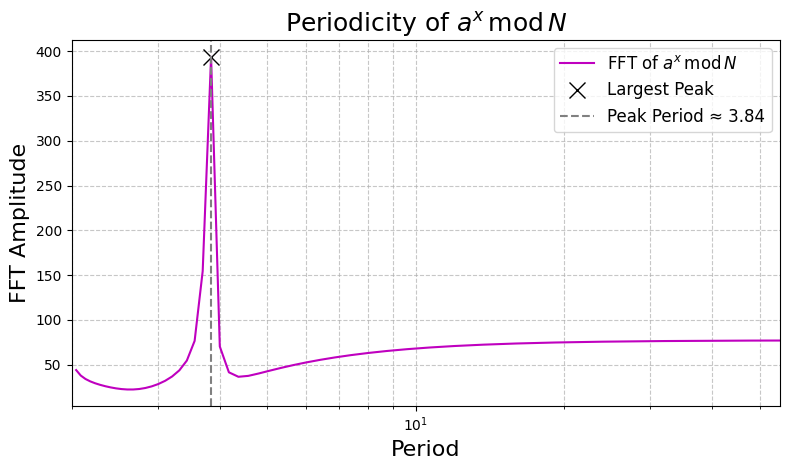

Largest peak period: 3.84


In [10]:

# FFT
Y = np.fft.fft(a_squared)

# Calculate frequency and period
y_len = int(len(Y)//2 - 1)
f = np.linspace(0, 1/2, y_len, endpoint=True)
period = 1 / f[1:-1]
yFFT = np.abs(Y[1:y_len-1])

# Find all peaks
peaks, _ = find_peaks(yFFT)

# Find the largest peak
largest_peak_idx = peaks[np.argmax(yFFT[peaks])]
largest_peak_period = period[largest_peak_idx]

# Plot
figsize = 8
plt.figure(figsize=(figsize, figsize * 0.6))
plt.style.use('default')
ax = plt.gca()

ax.plot(period, yFFT, '-m', label=r'FFT of $a^x \,\mathrm{mod}\, N$')
ax.plot(period[largest_peak_idx], yFFT[largest_peak_idx], 'xk', markersize=12, label='Largest Peak')

# Vertical line at largest peak
ax.axvline(largest_peak_period, color='gray', linestyle='--', label=f'Peak Period ≈ {largest_peak_period:.2f}')

# Labels and formatting
fs = 16
ax.set_xlabel('Period', fontsize=fs)
ax.set_ylabel('FFT Amplitude', fontsize=fs)
ax.set_title(r'Periodicity of $a^x \,\mathrm{mod}\, N$', fontsize=fs+2)
ax.set_xlim(2, N)
ax.set_xscale('log')

ax.grid(True, which="both", ls="--", alpha=0.7)
ax.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Print largest peak period
print(f"Largest peak period: {largest_peak_period:.2f}")


In [11]:
r=int(mod(2**2**largest_peak_period,N))
print('r=',r)

r= 53


In [12]:
print('N=',N)
print('r=',r)

print('a**(r//2)-1=', a**(r//2)-1 )
print('a**(r//2)+1=', a**(r//2)+1 )

print( 'mod(a**(r//2)-1,N)=', mod(a**(r//2)-1,N) )
print( 'mod(a**(r//2)+1,N)=', mod(a**(r//2)+1,N) )

guesses = [gcd(mod(a**(r//2)-1,N), N), gcd(mod(a**(r//2)+1,N), N)]

print('guesses',guesses)

N= 55
r= 53
a**(r//2)-1= 67108863
a**(r//2)+1= 67108865
mod(a**(r//2)-1,N)= 8
mod(a**(r//2)+1,N)= 10
guesses [np.int64(1), np.int64(5)]


5 is one of the factors! We can divide N by 5 and get the other factor 11!

# Conclusion

You have now run the minimal working example of Shor's Algorithm.

**Congratulations!**

The choice of N, p, q and 'a' were all made to simplify the circuit as much as possible while still giving a nontrivial result.

This course has focused on an 'engineering' perspective to quantum computing so we have gone through the nuts and bolts of how to run quantum algorithms gate by gate and circuit by circuit. There is much more to learn about quantum computing than we were able to cover in this short semester but hopefully now you have a foundation from which to begin your own quantum journey.


----

References:

1. https://openlearninglibrary.mit.edu/courses/course-v1:MITx+8.370.2x+1T2018/courseware/Week3/lectures_U2_5_factoring/

1. https://research.ibm.com/blog/factor-15-shors-algorithm

1. Realization of a scalable Shor algorithm - https://arxiv.org/abs/1507.08852

1. (Demonstration of Shor’s factoring algorithm for N = 21 on IBM quantum processors) https://www.nature.com/articles/s41598-021-95973-w

1. https://www.scottaaronson.com/qclec.pdf

1. https://tsmatz.wordpress.com/2019/05/22/quantum-computing-modulus-add-subtract-multiply-exponent/

1. Quantum arithmetic with the Quantum Fourier Transform ( https://arxiv.org/abs/1411.5949 )




# Homework 12 (due 5/5)

1. Create a new notebook just for the problem set
1. Work with a partner or group of three to solve the problems
1. Summarize your results in a short report and upload to gradescope
1. Include a link to your colab notebook code 
1. Make sure the link gives 'General access' for 'Anyone with the link' to comment (and view)

___


# HW Problems

  1. Generate a list of large prime numbers (p, q) and try factoring some large N's classically using the classical FFT to estimate the periodicity. How large of N's does this work for?

  1. What is the minimum number of qubits needed in the 'QFT' top register? Can the qubits be reused?

  1. What choice for 'a' requires the fewest two qubit gates for the function U? (hint: https://arxiv.org/abs/1507.08852 Figure 1. ). Draw the circuit.

  1. If  you had an infinite number of fully connected qubits with two qubit gate error rates of 0.1%. Also imagine that the circuit for the function U could be a simple Ripple Swap for any N. That is only scaling with the depth **and periodicity** as the log of N (the number of bits needed to represent N). Taking all of those assumptions estimate the largest N you could factor with 50% success.

(650 students) Work on your final project.

In [ ]:
'''
Exercise 1
'''


'\nExercise 1\n'

In [ ]:
'''
Exercise 2
'''


'\nExercise 2\n'